## Imports

In [1]:
import pandas as pd
import os
from openpyxl import Workbook
from simplified_scrapy import SimplifiedDoc, utils
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
pd.set_option('display.float_format', '{:.2f}'.format)

## Morningstar dataset conversion to Excel file (.xlsx)

In [ ]:
"""
import os
files = []
for i in os.walk('./datasets'):
    files= i[2]
    
print(files)
"""

In [ ]:
"""
def readFile(filename):
    xml = utils.getFileContent(filename)
    doc = SimplifiedDoc(xml)
    tables = doc.selects('Worksheet').selects('Row').selects('Cell').text # Get all data
    sheetNames = doc.selects('Worksheet>ss:Name()') # Get sheet name
    return sheetNames,tables,filename.split('/')[2].split('.')[0]

def to_Excel(sheetNames,tables, filename):
    wb = Workbook() # Create Workbook
    for i in range(len(sheetNames)):
        worksheet = wb.create_sheet(sheetNames[i]) # Create sheet
        for row in tables[i]:
            worksheet.append(row)
    print('./datasets_excel/'+ filename + '.xlsx')
    wb.save('./datasets_excel/'+ filename + '.xlsx') # Save file
"""

In [ ]:
"""
for filename in (os.listdir("./datasets")):
        name = filename.split('.')[0]
        print(name)
        
        dst = name + ".xml"
        src ='./datasets/'+ filename
        dst ='./datasets/'+ dst
          
        # rename() function will
        # rename all the files
        os.rename(src, dst)
"""

In [ ]:
"""
for file in files:
    to_Excel(*readFile("./datasets/" + file))
"""

## Import datasets into Pandas dataframes

In [2]:
files = []
for i in os.walk('./datasets_excel/'):
    files=i[2]

workbooks = {}
for file in files:
    workbooks[file.split('.')[0]] = pd.read_excel('./datasets_excel/' + file, sheet_name=None)

In [3]:
print(list(workbooks.keys()))

['ADH_FY', 'ADH_HY', 'ANZ_FY', 'ANZ_HY', 'BCI_FY', 'BCI_HY', 'BFG_FY', 'BFG_HY', 'BHP_FY', 'BHP_HY', 'BNL_FY', 'BNL_HY', 'BPG_FY', 'BPG_HY', 'BTR_FY', 'BTR_HY', 'CBA_FY', 'CBA_HY', 'CCC_FY', 'CCC_HY', 'CIM_FY', 'CIM_HY', 'CVR_FY', 'CVR_HY', 'DGX_FY', 'DGX_HY', 'DTZ_FY', 'DTZ_HY', 'GMN_FY', 'GMN_HY', 'HWK_FY', 'HWK_HY', 'JBH_FY', 'JBH_HY', 'LCT_FY', 'LCT_HY', 'MEB_FY', 'MEB_HY', 'MFG_FY', 'MFG_HY', 'MGC_FY', 'MGC_HY', 'MQG_FY', 'MQG_HY', 'NAB_FY', 'NAB_HY', 'NCM_FY', 'NCM_HY', 'NGI_FY', 'NGI_HY', 'REX_FY', 'REX_HY', 'RIO_FY', 'RIO_HY', 'RNO_FY', 'RNO_HY', 'SRX_FY', 'SRX_HY', 'SRZ_FY', 'SRZ_HY', 'WBC_FY', 'WBC_HY', 'WCC_FY', 'WCC_HY']


## Cleaning

### Normalising statement items (WIP)

In [4]:
statement_items = defaultdict(set)

for workbook in workbooks:
    for sheet in workbooks[workbook]:
        if sheet != 'Sheet' and 'Item' in workbooks[workbook][sheet]:
            statement_items[sheet].update(workbooks[workbook][sheet]['Item'])
            
statement_items.keys()

dict_keys(['Profit Loss', 'Balance Sheet', 'Cash Flow', 'Per Share Statisticts', 'Sundry Analysis', 'Growth Rates', 'Ratio Analysis', 'Asset Base Analysis'])

### Restructuring datasets and creating combined HY and FY dataset

In [5]:
workbooks_combined = defaultdict(dict)
workbooks_keys = list(workbooks.keys())

for i in range(len(workbooks)//2):
    for sheet in statement_items:
        workbook_FY = workbooks[workbooks_keys[i*2]] # Reading in the full-yearly statements
        workbook_HY = workbooks[workbooks_keys[i*2 + 1]] # Reading in the half-yearly statements
        new_sheet = _ 
        
        if sheet in workbook_FY:
            sheet_FY = workbook_FY[sheet].drop(['ASX Code', 'Company Name'], axis=1)
            sheet_HY = workbook_HY[sheet].drop(['ASX Code', 'Company Name'], axis=1)

            new_sheet = pd.concat([sheet_FY, sheet_HY], axis=1, join='inner')
            new_sheet = new_sheet.loc[:,~new_sheet.columns.duplicated()] # Drop extra 'item' 
            new_sheet = new_sheet.set_index(['Item'])
            
            new_sheet.columns = pd.to_datetime(new_sheet.columns, format='%m/%y')
            new_sheet = new_sheet.sort_index(axis=1)
            
            new_sheet = new_sheet.replace('--', 0, regex=True)
            new_sheet = new_sheet.astype('float')

            workbooks_combined[workbooks_keys[i*2].split('_')[0]][sheet] = new_sheet.transpose()    
        else:
            print("Missing tab:", workbooks_keys[i*2], sheet)            

Missing tab: ANZ_FY Sundry Analysis
Missing tab: CBA_FY Sundry Analysis
Missing tab: NAB_FY Sundry Analysis
Missing tab: WBC_FY Sundry Analysis


In [6]:
workbooks_separated = defaultdict(lambda: defaultdict(dict))
workbooks_keys = list(workbooks.keys())

for workbook in workbooks:
    for sheet in statement_items:       
        if sheet in workbooks[workbook]:
            new_sheet = workbooks[workbook][sheet].drop(['ASX Code', 'Company Name'], axis=1)
            
            new_sheet = new_sheet.set_index(['Item'])
            new_sheet.columns = pd.to_datetime(new_sheet.columns, format='%m/%y')
            new_sheet = new_sheet.sort_index(axis=1)
            
            new_sheet = new_sheet.replace('--', 0, regex=True)
            new_sheet = new_sheet.astype('float')

            workbooks_separated[workbook.split('_')[0]][workbook.split('_')[1]][sheet] = new_sheet.transpose()
        else:
            print("Missing tab:", workbook, sheet)            

Missing tab: ANZ_FY Sundry Analysis
Missing tab: ANZ_HY Sundry Analysis
Missing tab: CBA_FY Sundry Analysis
Missing tab: CBA_HY Sundry Analysis
Missing tab: NAB_FY Sundry Analysis
Missing tab: NAB_HY Sundry Analysis
Missing tab: WBC_FY Sundry Analysis
Missing tab: WBC_HY Sundry Analysis


In [ ]:
# workbooks_combined_test[ticker][HY or FY][sheet name][item name]
workbooks_separated['ADH']['HY']['Profit Loss']['Operating Revenue']

In [ ]:
workbooks_combined.keys()

In [ ]:
workbooks_combined['ADH']['Profit Loss'].head()

### Removing correlated features (WIP)

In [7]:
plt.figure(figsize=(10, 10))
cm = workbooks_separated['ADH']['FY']['Profit Loss'].corr().abs()
cm_sort = cm.unstack()
cm_sort = cm_sort.sort_values(kind="quicksort", ascending=False)
print(cm_sort)


Item                               Item                    
Operating Revenue                  Operating Revenue          1.00
PreTax Profit                      PreTax Profit              1.00
Operating Expenses                 Operating Expenses         1.00
EBITDA                             EBITDA                     1.00
Depreciation                       Depreciation               1.00
                                                              ... 
Weighted Average Number of Shares  Outside Equity Interests    NaN
EPS Adjusted (cents/share)         Abnormals Tax               NaN
                                   Outside Equity Interests    NaN
EPS After Abnormals (cents/share)  Abnormals Tax               NaN
                                   Outside Equity Interests    NaN
Length: 576, dtype: float64


<Figure size 720x720 with 0 Axes>

## Visualisation

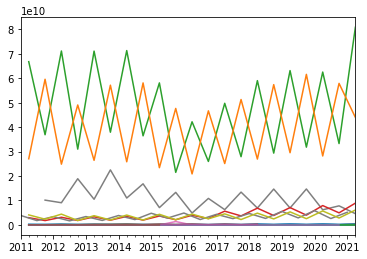

In [8]:
fig, ax = plt.subplots()

for workbook in workbooks_combined:
    if 'Operating Revenue' in workbooks_combined[workbook]['Profit Loss']:
        workbooks_combined[workbook]['Profit Loss']['Operating Revenue'].plot()


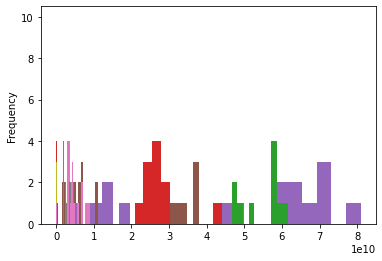

In [9]:
fig, ax = plt.subplots()

for workbook in workbooks_separated:
    for period in workbooks_separated[workbook]:
         if 'Operating Revenue' in workbooks_separated[workbook][period]['Profit Loss']:
                workbooks_separated[workbook][period]['Profit Loss']['Operating Revenue'].plot.hist()
   
